# Simple approach - CNN for vibration pattern classification

In this collab we will train a model that is aimed to perform vibration pattern classification -> anomaly detection. We collected data by placing the Arduino Nano 33BLE board on an amplifier and recording ~5 minutes of data for each condition: 60Hz frequency, 30 volume; 40HZ, 60vol; and 80Hz, 20vol.

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data

### Load the data

The .txt files can be found [here](https://github.com/Kalash157/TinyML_Predictive_Maintenance/tree/Justin/Collected_data)

**UPLOAD THOSE 3 FILES TO SESSION STORAGE!**

TODO: code to take them directly from GitHub

We define a function that reads the data into a data frame.

In [2]:
def readData(filePath):
    # attributes of the dataset
    columnNames = ['x-axis','y-axis','z-axis']
    #read the specified file using pandas function and return the data
    data = pd.read_csv(filePath, header=None, names=columnNames, sep='\t', na_values=';')
    return data

In [4]:
dataset_1 = readData("capture1_60hz_30vol.txt")
dataset_2 = readData("capture2_40hz_60vol.txt")
dataset_3 = readData("capture3_80HZ_20vol.txt")

In order to be able to plot the signals, we add a timestamp for each reading.

😖: Maybe we should be recording this when we record the data (and normalize the values in a smaller range after), in order to avoid assuming that the readings are qually spaced. *- Talk to Justin he has the amplifier*

In [5]:
# Add a new column for sequential timestamps
dataset_1['timestamp'] = np.arange(1, len(dataset_1) + 1)
dataset_2['timestamp'] = np.arange(1, len(dataset_2) + 1)
dataset_3['timestamp'] = np.arange(1, len(dataset_3) + 1)

### Visualize the data


We define functions that take the data and create 3 plots (for the x, y, z dimensions). This will allow us to inspect the vibration patterns.


In [6]:
# defining the function to plot a single axis data
# setup color, title, limit and add grid.
def plotAxis(axis, x, y, title):
    axis.plot(x, y, color='green', linewidth=1)
    axis.set_title(title)
    axis.xaxis.set_visible(False)
    axis.set_ylim([min(y)-np.std(y), max(y)+np.std(y)])
    axis.set_xlim([min(x), max(x)])
    axis.grid(True)

# defining a function to plot the data for a given vibration pattern
def plotVibPattern(data, hz, vol):
    # make subplots of x, y, z over timestamp
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(20,10), sharex=True)
    plotAxis(ax0, data['timestamp'], data['x-axis'], 'X-AXIS')
    plotAxis(ax1, data['timestamp'], data['y-axis'], 'Y-AXIS')
    plotAxis(ax2, data['timestamp'], data['z-axis'], 'Z-AXIS')
    # set the size and title
    plt.subplots_adjust(hspace=0.2)
    title = "Accelerometer data for " + hz + "HZ and " + vol + " volume"
    fig.suptitle(title)
    plt.subplots_adjust(top=0.9)
    plt.show()

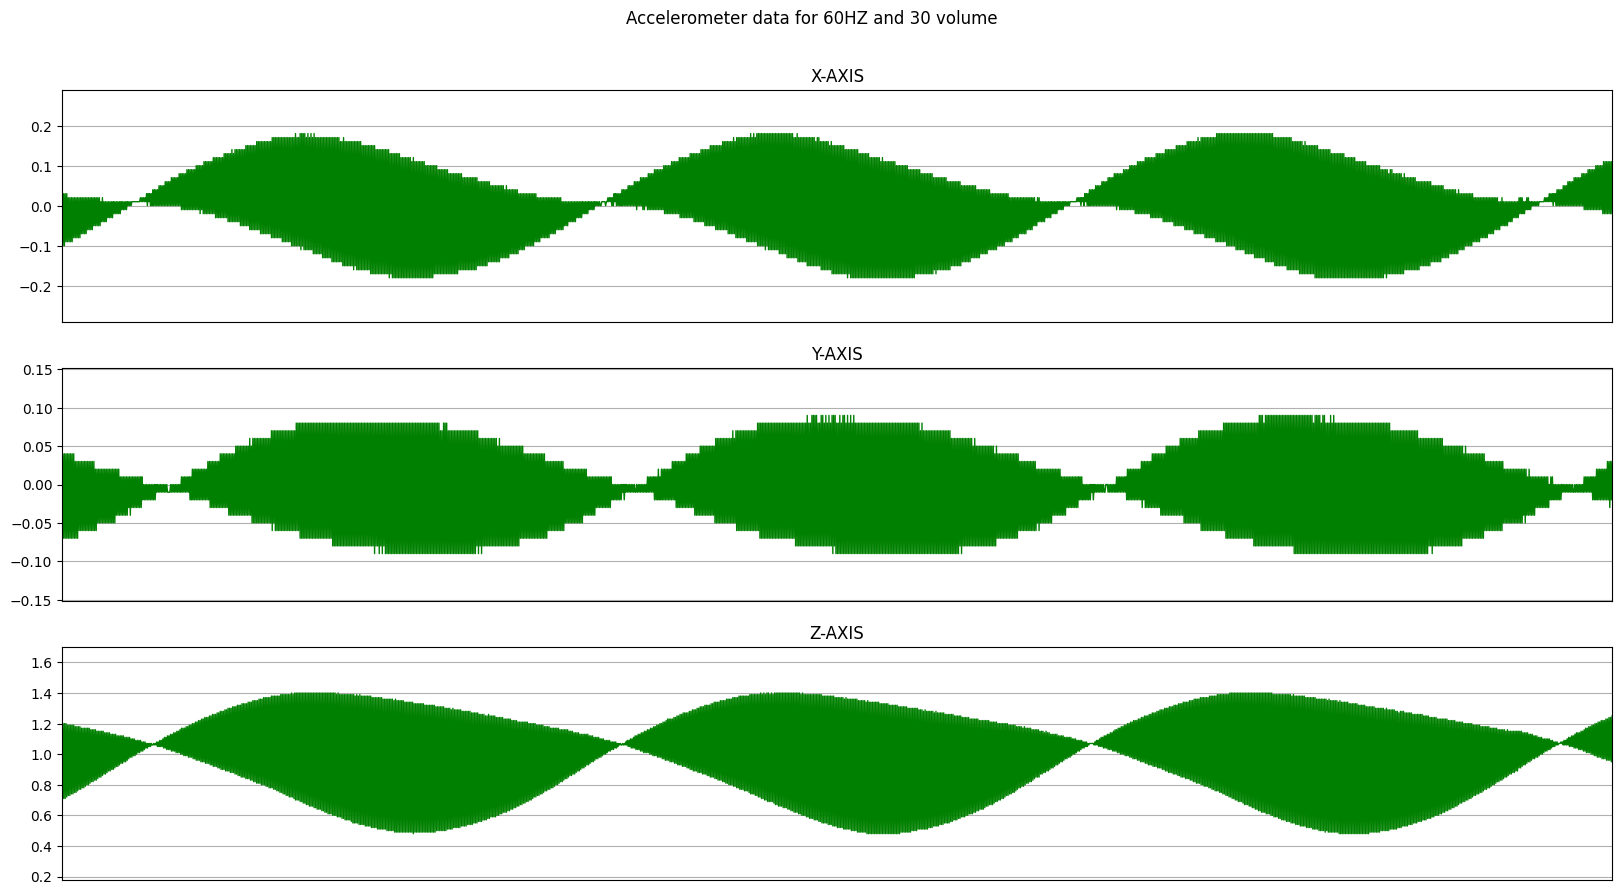

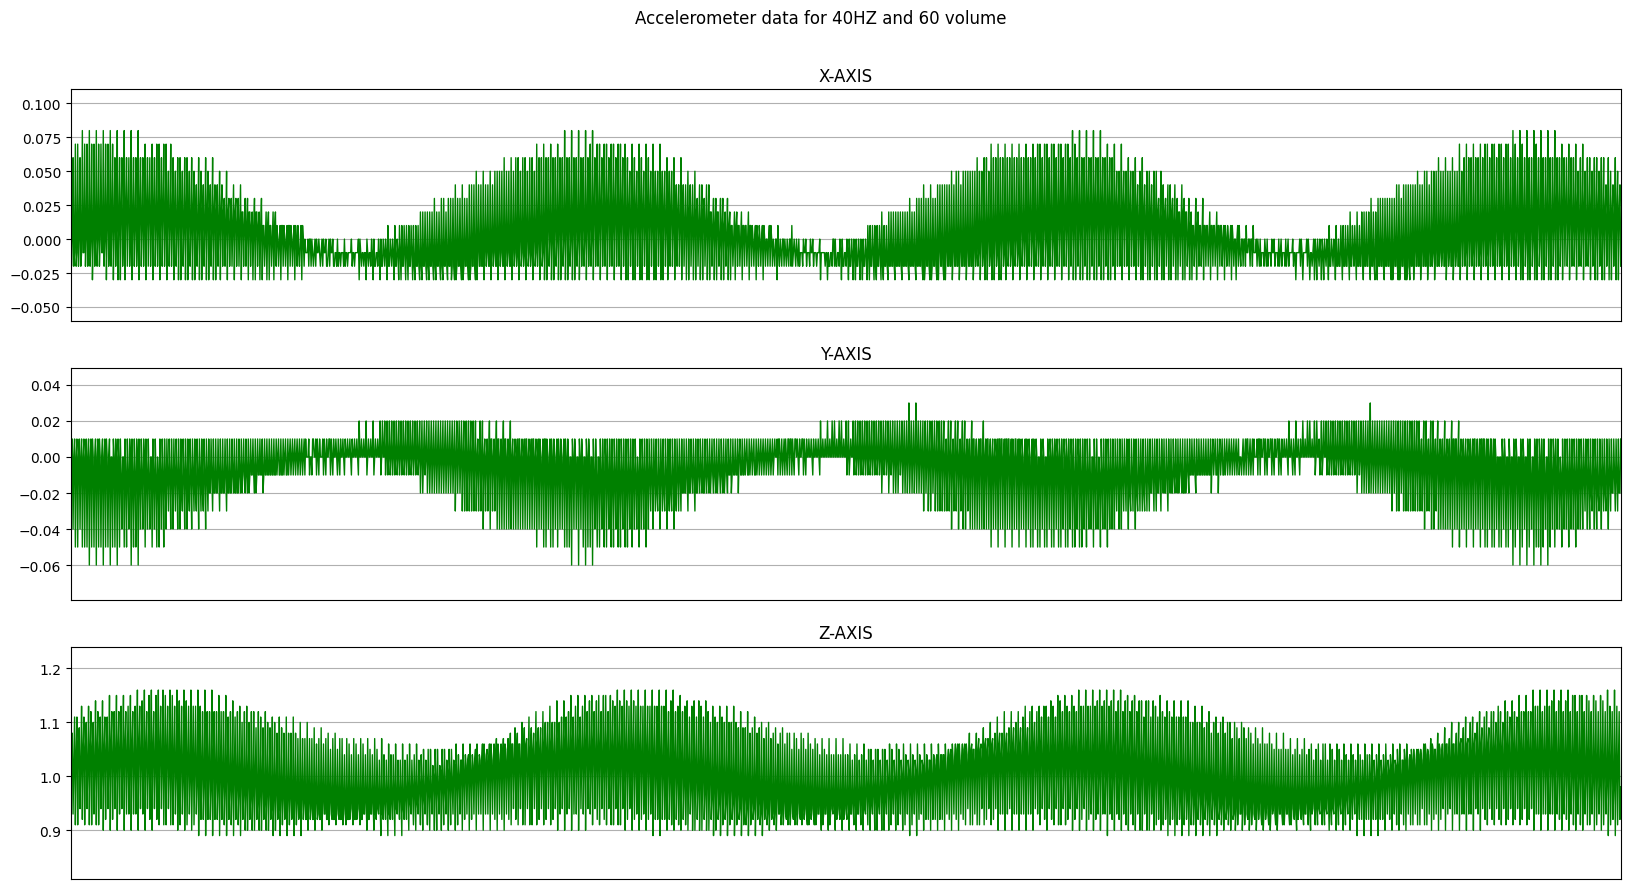

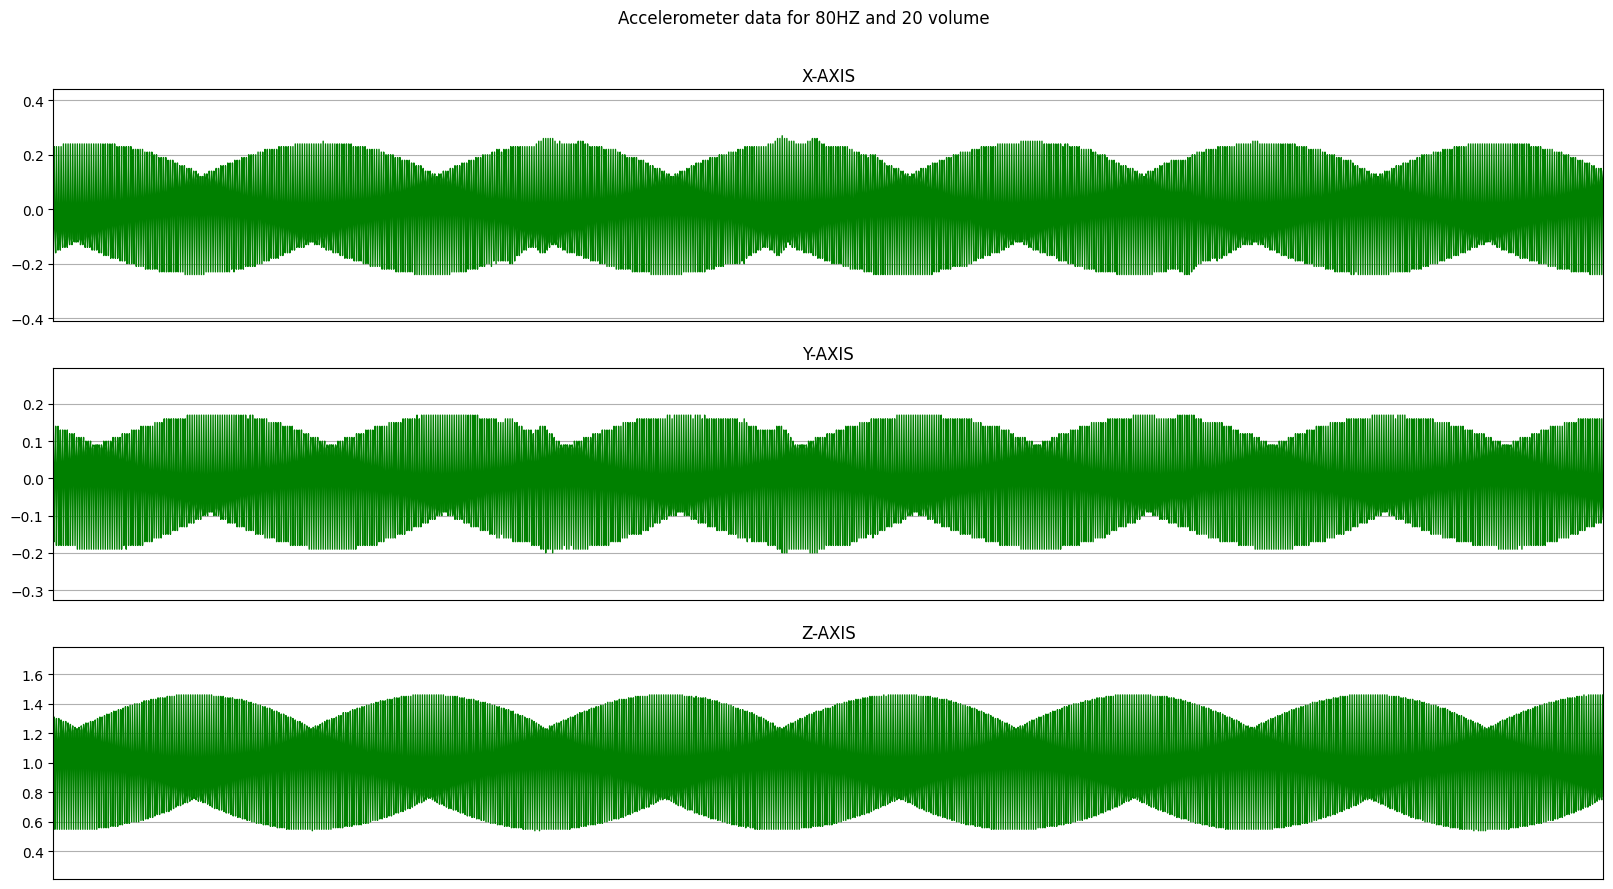

In [7]:
#select a subset of 2000 samples for plotting
subset_1 = dataset_1[:2000]
plotVibPattern(subset_1, "60", "30")
subset_2 = dataset_2[:2000]
plotVibPattern(subset_2, "40", "60")
subset_3 = dataset_3[:2000]
plotVibPattern(subset_3, "80", "20")

### Pre-process the data

Before moving on to the NN part, we need to make sure that our data is pre-processed properly.

⚡Remember that every pre-processing step done here will have to be done when we deploy the model as well, so really think about the complexity of the steps that you are making here.

### Train test split

First, we need to set aside some of our data for testing. We do this in order to be able to accurately report the performance of our model at the end. This means that we have to refrain from touching this data until the model is done!

We will keep thefirst 10% of the data from each condition for testing purposes. The following 90% will be used for training the model.

In [8]:
test_data_1 = dataset_1[:int(dataset_1.shape[0] * 10 / 100)]
test_data_2 = dataset_2[:int(dataset_2.shape[0] * 10 / 100)]
test_data_3 = dataset_3[:int(dataset_3.shape[0] * 10 / 100)]

train_data_1 = dataset_1[int(dataset_1.shape[0] * 10 / 100):]
train_data_2 = dataset_2[int(dataset_2.shape[0] * 10 / 100):]
train_data_3 = dataset_3[int(dataset_3.shape[0] * 10 / 100):]

Small check that we are not loosing / overlapping data:

In [9]:
print(train_data_1.shape[0] + test_data_1.shape[0] == dataset_1.shape[0])
print(train_data_2.shape[0] + test_data_2.shape[0] == dataset_2.shape[0])
print(train_data_3.shape[0] + test_data_3.shape[0] == dataset_3.shape[0])

True
True
True


### Creating segments

In order to make an inference, we will feed the network with 24 readings. The network will try to look for a pattern in the given segment and classify it in one of the 3 known classes, or label it us undefined if the confidence in the answer is too low.

To train such a model, we need to create such segments of data. They will each contain 24 readings and have 50% overlap with each other.

In [10]:
def windows(data,size):
    start = 0
    while start< data.count():
        yield int(start), int(start + size)
        start+= (size/2)

def split_data(data, window_size = 24):
    segments = np.empty((0,window_size,3))
    for (start, end) in windows(data['timestamp'],window_size):
        x = data['x-axis'][start:end]
        y = data['y-axis'][start:end]
        z = data['z-axis'][start:end]

        if(len(data['timestamp'][start:end])==window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
    return segments

In [11]:
segments_1 = split_data(train_data_1)
segments_2 = split_data(train_data_2)
segments_3 = split_data(train_data_3)

In [12]:
print("First class")
print(segments_1.shape)
print("Second class")
print(segments_2.shape)
print("Third class")
print(segments_3.shape)

First class
(2722, 24, 3)
Second class
(2705, 24, 3)
Third class
(2714, 24, 3)


We have 2722 segments of the first class, 2705 for the second and 2714 for the third. Together those will form our training dataset.

### Normalizing the training data (the segments)

The way our final application will work is that we will continuously capture data and put it in a buffer. Once the buffer will be full (24 readings), we will have to make an inference. Therefore, every segment will be normalized individually.

We will therefore normalize each of our segments before training the network on them.

In [13]:
def min_max_scaling(dataset):
    # Define the min and max values for each axis
    min_values = np.min(dataset, axis=0)
    max_values = np.max(dataset, axis=0)

    # Apply Min-Max scaling to each axis
    normalized_data = (dataset - min_values) / (max_values - min_values)

    return normalized_data

In [14]:
# Create a list to store the normalized segments
normalized_segments_1 = []
normalized_segments_2 = []
normalized_segments_3 = []

# Normalize segments for train_data_1
for segment in segments_1:
    normalized_segment = min_max_scaling(segment)
    normalized_segments_1.append(normalized_segment)

# Normalize segments for train_data_2
for segment in segments_2:
    normalized_segment = min_max_scaling(segment)
    normalized_segments_2.append(normalized_segment)

# Normalize segments for train_data_3
for segment in segments_3:
    normalized_segment = min_max_scaling(segment)
    normalized_segments_3.append(normalized_segment)

# Convert the lists to numpy arrays
normalized_segments_1 = np.array(normalized_segments_1)
normalized_segments_2 = np.array(normalized_segments_2)
normalized_segments_3 = np.array(normalized_segments_3)

Lastly, we will merge everything into one list

In [15]:
merged_normalized_segments = np.concatenate([normalized_segments_1, normalized_segments_2, normalized_segments_3], axis=0)

### Create a list of labels

Last but not least, we need to create lists that will hold the labels for the segments

😖: There is probably a smarter way to do this, but oh well...

The possible vibration patterns will be 0 (60Hz, 30vol), 1 (40Hz, 60vol) or 2 (80Hz, 20vol). labels_x hold those single digit labels for the segments.

To train the network we will want the labels to be represented as vectors, so we will use the one-hot-encoded representation of the labels (i.e. 0 is [1 0 0], 1 is [0 1 0] and 2 is [0 0 1]).

In [16]:
labels_1 = np.full(segments_1.shape[0], 0)
labels_2 = np.full(segments_2.shape[0], 1)
labels_3 = np.full(segments_3.shape[0], 2)

all_labels = np.concatenate((labels_1, labels_2, labels_3))
one_hot_encoded = np.asarray(pd.get_dummies(all_labels),dtype = np.int8)

one_hot_encoded_1 = one_hot_encoded[:segments_1.shape[0]]
one_hot_encoded_2 = one_hot_encoded[segments_1.shape[0]:(segments_1.shape[0] + segments_2.shape[0])]
one_hot_encoded_3 = one_hot_encoded[(segments_1.shape[0] + segments_2.shape[0]):]

labels = np.concatenate((one_hot_encoded_1, one_hot_encoded_2, one_hot_encoded_3))

## Train a model on the normalized segmets, 3 classes

Now we can create our neural network that will classify the segments. For the task, we will use a Convolutional Neural Network that will take the 24x3 data segment and label it as one of the 3 possible classes.

The network will contain convolution layers, that will look for features in the data, as well as dense layers that will deal with the classification task itself.

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras import optimizers

#Convolutional Neural network model to train on the vibrational pattern
def TrainingModel():
    model = Sequential()
    # adding the first convolutionial layer with 24 filters and 2 by 1 kernal size, using the rectifier as the activation function
    model.add(Conv2D(8, (4,1),input_shape=(24, 3,1),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,1),strides=(2,1),padding='valid'))
    model.add(Flatten())
    # adding first fully connected layer with 12 units
    #model.add(Dense(12, activation='relu'))
    # adding the dropout layer to avoid overfitting
    model.add(Dropout(0.3))
    # adding softmax layer for the classification
    model.add(Dense(3, activation='softmax'))
    # Compiling the model to generate a model
    adam = optimizers.Adam()
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.summary()
    return model

In [18]:
import random
# shuffle the data a bit: merged_normalized_segments and labels need shuffling in unison

# Shuffle two lists with same order
# Using zip() + * operator + shuffle()
temp = list(zip(merged_normalized_segments, labels))
random.shuffle(temp)
res1, res2 = zip(*temp)
# res1 and res2 come out as tuples, and so must be converted to lists.
res1, res2 = np.array(res1), np.array(res2)

In [19]:
model = TrainingModel()
history = model.fit(res1, res2, validation_split=0.2,epochs=10,batch_size=5, shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 21, 3, 8)          40        
                                                                 
 max_pooling2d (MaxPooling2  (None, 10, 3, 8)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 240)               0         
                                                                 
 dropout (Dropout)           (None, 240)               0         
                                                                 
 dense (Dense)               (None, 3)                 723       
                                                                 
Total params: 763 (2.98 KB)
Trainable params: 763 (2.98 KB)
Non-trainable params: 0 (0.00 Byte)
__________________________

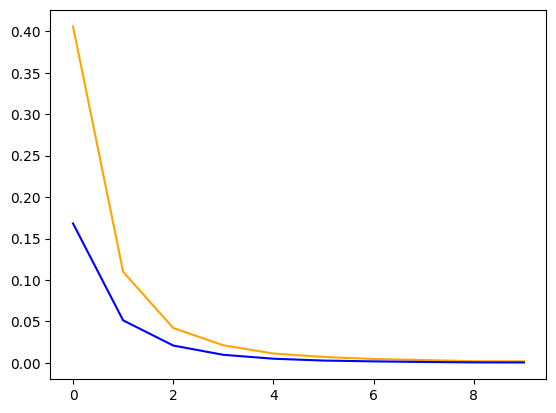

In [20]:
plt.plot(history.history['loss'], color='orange')
plt.plot(history.history['val_loss'], 'b')

## Testing on the set-aside test data

Now we will create segments (with no overlap, but normalized) from the test data we set aside at the beginning. Let's see how the model will perform.

In [21]:
# Create segments from the test data
def windows(data,size):
    start = 0
    while start< data.count():
        yield int(start), int(start + size)
        start+= size

def split_data(data, window_size = 24):
    segments = np.empty((0,window_size,3))
    #labels= np.empty((0))
    for (start, end) in windows(data['timestamp'],window_size):
        x = data['x-axis'][start:end]
        y = data['y-axis'][start:end]
        z = data['z-axis'][start:end]

        if(len(data['timestamp'][start:end])==window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            #labels = np.append(labels,l)
    return segments#, labels

test_segments_1 = split_data(test_data_1)
test_segments_2 = split_data(test_data_2)
test_segments_3 = split_data(test_data_3)

In [22]:
# Normalize the segments
test_normalized_segments = []

for segment in test_segments_1:
    normalized_segment = min_max_scaling(segment)
    test_normalized_segments.append(normalized_segment)

for segment in test_segments_2:
    normalized_segment = min_max_scaling(segment)
    test_normalized_segments.append(normalized_segment)

for segment in test_segments_3:
    normalized_segment = min_max_scaling(segment)
    test_normalized_segments.append(normalized_segment)

# Convert the lists to numpy arrays if needed
test_normalized_segments = np.array(test_normalized_segments)

In [23]:
test_normalized_segments.shape

(451, 24, 3)

In [24]:
test_labels_1 = np.full(test_segments_1.shape[0], 0)
test_labels_2 = np.full(test_segments_2.shape[0], 1)
test_labels_3 = np.full(test_segments_3.shape[0], 2)

test_all_labels = np.concatenate((test_labels_1, test_labels_2, test_labels_3))
test_one_hot_encoded = np.asarray(pd.get_dummies(test_all_labels),dtype = np.int8)

test_one_hot_encoded_1 = test_one_hot_encoded[:test_segments_1.shape[0]]
test_one_hot_encoded_2 = test_one_hot_encoded[test_segments_1.shape[0]:(test_segments_1.shape[0] + test_segments_2.shape[0])]
test_one_hot_encoded_3 = test_one_hot_encoded[(test_segments_1.shape[0] + test_segments_2.shape[0]):]

test_labels = np.concatenate((test_one_hot_encoded_1, test_one_hot_encoded_2, test_one_hot_encoded_3))

In [25]:
test_labels.shape

(451, 3)

In [26]:
loss_100, accuracy_100 = model.evaluate(test_normalized_segments, test_labels)

15/15 [==============================] - 0s 1ms/step - loss: 3.7284e-04 - accuracy: 1.0000


In [27]:
model.save("saved_model/my_model")

Perform a simple conversion to TF Lite in order to visualize the model and see what tf Im doing

In [28]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model/my_model")
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

I downloaded the .tflite file and uploaded it to https://netron.app/ in order to visualize the architecture of the model.

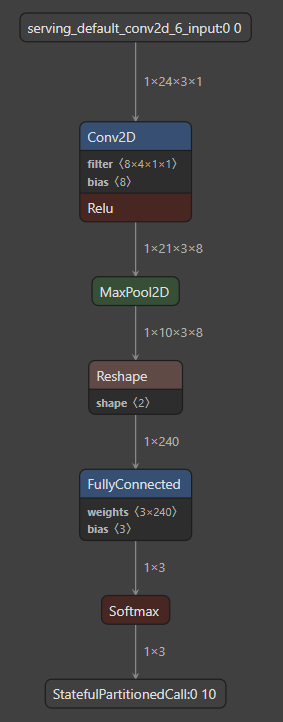

Inspect the size of the model

**The Arduino Nano 33 BLE Sense has 1 MB Flash + 256 KB RAM.**

In [29]:
tf.lite.experimental.Analyzer.analyze(model_path="model.tflite",
                                      model_content=None,
                                      gpu_compatibility=False)

=== model.tflite ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the CONV_2D op takes
tensor #0 and tensor #2 and tensor #1 as input and produces tensor #6 as output.

Subgraph#0 main(T#0) -> [T#10]
  Op#0 CONV_2D(T#0, T#2, T#1) -> [T#6]
  Op#1 MAX_POOL_2D(T#6) -> [T#7]
  Op#2 RESHAPE(T#7, T#4[-1, 240]) -> [T#8]
  Op#3 FULLY_CONNECTED(T#8, T#5, T#3) -> [T#9]
  Op#4 SOFTMAX(T#9) -> [T#10]

Tensors of Subgraph#0
  T#0(serving_default_conv2d_input:0) shape_signature:[-1, 24, 3, 1], type:FLOAT32
  T#1(sequential/conv2d/BiasAdd/ReadVariableOp) shape:[8], type:FLOAT32 RO 32 bytes, buffer: 2, data:[0.145022, -0.0911986, 0.0806188, -0.255305, 0.1437, ...]
  T#2(sequential/conv2d/Conv2D) shape:[8, 4, 1, 1], type:FLOAT32 RO 128 bytes, buffer: 3, data:[0.823084, -0.0830224, -0.0998, -0.919907, 0.383983, ...]
  T#3(sequential/dense/BiasAdd/ReadVariableOp) shape:[3], type:FLOAT32 RO 12 bytes, buffer: 4, dat

## Quantize the model


test_normalized_segments - the test inputs, numpy array, (451, 24, 3)

test_labels - the expected outputs, numpy.ndarray, (451, 3)


In [31]:
def representative_data_gen():
    for input_value in test_normalized_segments:
        yield tf.expand_dims(tf.expand_dims(tf.convert_to_tensor(input_value, dtype=tf.float32), -1), 0)

In [32]:
data = representative_data_gen()

In [33]:
for d in data:
  break
d.shape

TensorShape([1, 24, 3, 1])

In [34]:
model.predict(d)

1/1 [==============================] - 0s 60ms/step


array([[9.9999988e-01, 6.2404624e-08, 0.0000000e+00]], dtype=float32)

In [35]:
interpreter = tf.lite.Interpreter(model_content = tflite_model)
print(interpreter.get_signature_list())

{'serving_default': {'inputs': ['conv2d_input'], 'outputs': ['dense']}}


In [39]:
# asta e bun cred

####### https://blog.tensorflow.org/2021/03/a-tour-of-savedmodel-signatures.html
###### https://www.tensorflow.org/lite/performance/post_training_quantization

import tensorflow as tf

# Save the model as a SavedModel
tf.saved_model.save(model, 'saved_model')

# Convert the SavedModel to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
converter.optimizations = [tf.lite.Optimize.DEFAULT]


# Convert your DataFrame to a TensorFlow Dataset
#test_dataset = tf.data.Dataset.from_tensor_slices(test_normalized_segments.values)

# Define the batch size
batch_size = 32

def representative_data_gen():
    for input_value in test_normalized_segments:
        #yield tf.expand_dims(tf.expand_dims(tf.convert_to_tensor(input_value, dtype=tf.float32), -1), 0)
        yield {"conv2d_input": tf.expand_dims(tf.expand_dims(tf.convert_to_tensor(input_value, dtype=tf.float32), -1), 0)}

'''
# Code from EDX Tiny ML fundamentals course
def representative_data_gen():
    for input_value in test_batch.take(100):
        yield [tf.cast(input_value, tf.float32)]  # Convert to FLOAT32]
'''

converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]


# Save the TensorFlow Lite model
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)

In [40]:
tf.lite.experimental.Analyzer.analyze(model_path="converted_model.tflite",
                                      model_content=None,
                                      gpu_compatibility=False)

=== converted_model.tflite ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the QUANTIZE op takes
tensor #0 as input and produces tensor #6 as output.

Subgraph#0 main(T#0) -> [T#12]
  Op#0 QUANTIZE(T#0) -> [T#6]
  Op#1 CONV_2D(T#6, T#5, T#4[5105, -4692, 8062, -3829, 4806, ...]) -> [T#7]
  Op#2 MAX_POOL_2D(T#7) -> [T#8]
  Op#3 RESHAPE(T#8, T#1[-1, 240]) -> [T#9]
  Op#4 FULLY_CONNECTED(T#9, T#3, T#2[1841, 2554, -2698]) -> [T#10]
  Op#5 SOFTMAX(T#10) -> [T#11]
  Op#6 DEQUANTIZE(T#11) -> [T#12]

Tensors of Subgraph#0
  T#0(serving_default_conv2d_input:0) shape_signature:[-1, 24, 3, 1], type:FLOAT32
  T#1(sequential/flatten/Const) shape:[2], type:INT32 RO 8 bytes, buffer: 2, data:[-1, 240]
  T#2(sequential/dense/BiasAdd/ReadVariableOp) shape:[3], type:INT32 RO 12 bytes, buffer: 3, data:[1841, 2554, -2698]
  T#3(sequential/dense/MatMul) shape:[3, 240], type:INT8 RO 720 bytes, buffer: 4, data:[9, ., .